In [1]:
import cv2, matplotlib, scipy.ndimage, numba
import numpy as np
import pandas as pd
import numpy.linalg as npMat
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipyfilechooser import FileChooser
from IPython.display import display
from IPython.core.display import HTML
import sys, os, time


# Visualization

The data should be saved in a general form (like `xml` or `panda binary file` or `numpy compressed`), but there we use separate csv file instead (where shape is `600 * 400`).

Make sure that `kernel.csv`, `result.csv` is placed under the same folder of the notebook. 

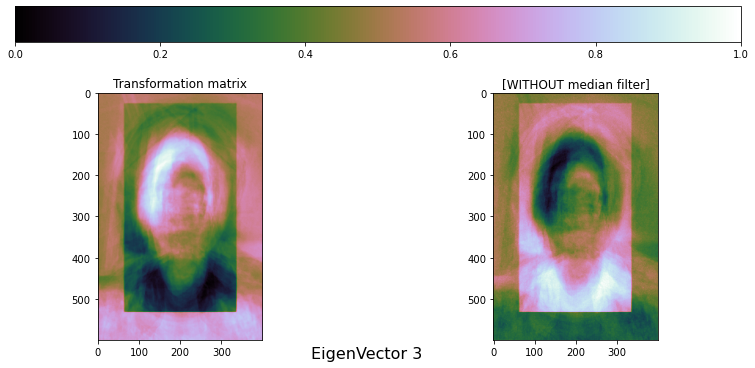

Output()

In [2]:
# shapeOriginal = [600, 400]  # identical to kernel.csv's original shape. now in `utils`
# read train data (format as `pMat/coeff, eNorVec/score, eVal/latent = pca()` in Matlab, with `utils`)
npDict = np.load("train.npz")
kValue, kernel, trainData, utils = npDict['eVal'], npDict['eNorVec'], npDict['pMat'], npDict['utils']
utilsLink = utils[:, 1].T  # Specify

# read another data to compare.
try:
    contrastKernel = np.load("train.nomedian.npz")
    if not isinstance(contrastKernel, np.ndarray):
        contrastTrainData = contrastKernel['pMat']
        contrastKernel = contrastKernel['eNorVec']
except Exception:
    contrastKernel = np.zeros((kernel.shape[0], kernel.shape[1]))


def imshowShape(ySelect, cmapString="cubehelix"):
    try:
        plt.figure(figsize=(13, 10))  # define a figure
        plt.figtext(.5, .1, "EigenVector {}".format(
            ySelect), fontsize=16, ha="center")

        # https://matplotlib.org/stable/tutorials/colors/colorbar_only.html and https://stackoverflow.com/questions/16595138/standalone-colorbar-matplotlib
        plt.subplot(2, 1, 1)  # horizontal plot area for colorbar
        plt.gca().set_visible(False)  # ADD to ANY empty plot figure to omit empty output
        plt.colorbar(plt.cm.ScalarMappable(
            cmap=plt.get_cmap(cmapString)), orientation="horizontal")

        plt.subplot(2, 2, 3)  # area for kernel/Transformation matrix
        plt.imshow(kernel[:, ySelect].reshape(
            (utils[0, 2], utils[0, 3])), cmap=plt.get_cmap(cmapString))
        plt.title("Transformation matrix")

        plt.subplot(2, 2, 4)  # area for compare data
        plt.imshow(contrastKernel[:, ySelect].reshape(
            (600, 400)), cmap=plt.get_cmap(cmapString))
        plt.title("[WITHOUT median filter]")
    except ValueError as e:
        print("Input your cmapString, e.g. `cubehelix`?\nPython report ValueError: {}".format(e))


imshowShape(3)  # print figure per eigenVector
# or an interactive figure
ui0_0 = widgets.IntSlider(min=0, max=min(kernel.shape[1], contrastKernel.shape[1]) - 1,
                          step=1, value=20, description="Which eigenvector?")
ui0_1 = widgets.Text(value="cubehelix", description="Color Map:")
ui0 = widgets.HBox([ui0_0, ui0_1])
output0 = widgets.interactive_output(
    imshowShape, {'ySelect': ui0_0, 'cmapString': ui0_1})
# See <https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html#More-control-over-the-user-interface:-interactive_output>
display(ui0, output0)


# Classifier


In [3]:
import hw2
import hw1


def cropTestMatrix(imageMatrix):  # used by readFromWebCallback
    # cv2.resize(imageMatrix)
    pass


def readFromPath(pathFromWidgets, hw1Var=1, hw2Var=1):  # like class1.ipynb#block2
    try:
        imMatrix = cv2.imread(pathFromWidgets)  # read testdata from file
        # default: Convert to Grey with weighted mean.
        imMatrix = hw1.colorSpaceMatrix(BGR=imMatrix).space[hw1Var]
        # default: With the process of Median Filter
        imMatrix = hw2.hw2Config[hw2Var](imMatrix)
        # default: With the process of Median Filter
        imMatrix = hw2.hw2Config[hw2Var](imMatrix)
        if imMatrix.shape[0] != utils[0][2] or imMatrix.shape[1] != utils[0][3]:
            raise IndexError("Shape dismatch.")
        return imMatrix.flatten('C')  # flatten like reshape, row-major order
    except Exception as e:
        print("Error when read {}: {}".format(pathFromWidgets, e))
        return False


def readFromWebCallback(rawRtcStream):
    pass


def processMatrix(imageMatrix):
    # per kernel's k(y axis), dot product of imageMatrix and kernel[:, k]
    # See more <https://ajcr.net/Basic-guide-to-einsum/> @cite ajcr_2015
    # return np.einsum("i,ik->k", imageMatrix, contrastKernel) # TODO contrast
    return np.einsum("i,ik->k", imageMatrix, kernel)


@numba.jit(nopython=True)
def classifyKnn(imageFeature, calcAmount: int, kNum: int) -> tuple[list, int, int]:
    '''This function use an O(nm) easiest way to implement the search of each
    scan data's k nearest neighbor.

    With numba.jit(nopython=True)

    return List, Recognition face, This face's first match image's number
    '''
    if calcAmount > kernel.shape[0]:
        raise IndexError("arg Dimension can't exceed kernel's shape[0].")
    # DO NOT use [[]] * calcAmount in numba
    returnList = [[0.0, 0, 0] for i in range(utils[-1, 1])]
    # utils[-1][1] indicates the largest number of dataset image
    for i in range(utils[-1, 1]):
        # returnList[i][0] = npMat.norm(imageFeature[: calcAmount] - contrastTrainData[i, : calcAmount]) # TODO contrast
        returnList[i][0] = npMat.norm(
            imageFeature[: calcAmount] - trainData[i, : calcAmount])  # euler's distance
        returnList[i][1] = i  # the corresponding dataset image
        returnList[i][2] = utils[np.searchsorted(
            utilsLink, i)][0]  # the corresponding face
    returnList.sort(reverse=False)  # sorted by [0]: euler's distance

    resultList = np.array(returnList, dtype=np.int64)[
        : kNum, 2]  # extract kNN's face number
    # count the occurrence of each number, and save them with their number index
    resultMiddle = np.bincount(resultList)
    result = np.argwhere(resultMiddle == resultMiddle.max())  # NN in k range
    while result.size != 1:  # if multiple NN in k range, shrink the range by 1
        kNum -= 1
        resultMiddle[resultList[kNum]] -= 1
        result = np.argwhere(resultMiddle == resultMiddle.max())

    return returnList, result[0, 0], returnList[np.argmax(resultList == result[0, 0])][1]

# %timeit classifyKnn(np.array([0 for i in range(kernel.shape[1])]), 40, 10)


In [4]:
testFeature = []  # Prepare for test dataset.
# one element from enumerate() like (0, (1, 10, 600, 400))
for count0, i in enumerate(utils):
    # in case of multiple order num
    imWait = readFromPath("./dataset/test/s{}_11.jpg".format(i[0], i[0]))
    if not isinstance(imWait, bool):  # not empty, not return False
        testFeature.append([processMatrix(imWait), i[0]])


Error when read ./dataset/test/s25_11.jpg: axis 2 is out of bounds for array of dimension 0
Error when read ./dataset/test/s27_11.jpg: axis 2 is out of bounds for array of dimension 0


# Result
cross-walks of test dataset v.s. feature dataset.

In [5]:
error_count = 0
for i in range(len(testFeature)):
    # a well-behaved variable, calcDimension = 13, k = 7
    a, b, _ = classifyKnn(testFeature[i][0], 12, 4)
    if testFeature[i][1] != b:  # dismatched
        print(testFeature[i][1], b, np.array(a)[:4])
        error_count += 1
    elif a[0][0] < 1e3:
        print("test face {a} is too close to dataset(s{a}_{b})?".format(
            a=testFeature[i][1], b=int(a[0][1] % 10 + 1)))  # TODO %10
print("Error rate is {}.".format(error_count / len(testFeature)))
# plt.imshow(readFromPath("./dataset/test/s12_11.jpg").reshape(600, 400), cmap=plt.get_cmap('gray'))


test face 3 is too close to dataset(s3_1)?
test face 4 is too close to dataset(s4_3)?
test face 9 is too close to dataset(s9_1)?
12 3 [[7.52400809e+03 1.70000000e+01 3.00000000e+00]
 [8.81492647e+03 1.80000000e+01 3.00000000e+00]
 [8.87130707e+03 1.90000000e+01 3.00000000e+00]
 [8.87635220e+03 1.60000000e+01 3.00000000e+00]]
test face 22 is too close to dataset(s22_3)?
Error rate is 0.05.


In [6]:
try:
    # File name, after process matrix, face number, display state
    fileList = [
        ['./dataset/test/s{}_11.jpg'.format(i[1]), i[0], i[1], True] for i in testFeature]
    # del testFeature
except NameError:
    pass


def imgHtmlTag(src):
    return "<img src='{}' width='60px'>".format(src)


def imgFNHtmlTag(face, num):
    return imgHtmlTag("./dataset/s{face}/s{face}_{num}.jpg".format(
        face=int(face), num=int(num) % 10 + 1))  # TODO %10


def showTable(calcAmount, kNum, mode):
    tableList = []
    if mode >= 0: # select a file
        fileListSel = [fileList[mode]]
    else: # using filter
        fileListSel = fileList
    for i, fileArray in enumerate(fileListSel):
        if not fileArray[3]:
            continue
        tempTuple = classifyKnn(fileArray[1], calcAmount, kNum)
        tableList.append((
            (imgHtmlTag(fileArray[0]), fileArray[2]), # Selected image
            (imgFNHtmlTag(tempTuple[1], tempTuple[2]), tempTuple[1]), # Recognition face and its first match
            tempTuple[0]
        ))
    df = pd.DataFrame([[i[0][0], i[1][0], i[0][1], i[1][1]] +
                             # [[i[2][j][0]] + [imgFNHtmlTag(i[2][j][1], i[2][j][2])] for j in range(1, 3)]
                             [imgFNHtmlTag(i[2][0][2], i[2][0][1]), i[2][0][0]] +
                             [imgFNHtmlTag(i[2][1][2], i[2][1][1]), i[2][1][0]] +
                             [imgFNHtmlTag(i[2][2][2], i[2][2][1]), i[2][2][0]]
                             for i in tableList
                             ], columns=["Image", "First match", "Face", "Reco Face",
                                         "Image 1st", "Distance 1st", "Image 2nd", "Distance 2nd", "Image 3rd", "Distance 3rd"])
    if mode == -2:
        df = df[df["Face"] != df["Reco Face"]]
    # df["Distance"] = df["Distance"].astype(float)
    # print(df.dtypes)
    # https://coderedirect.com/questions/691950/how-do-i-style-a-subset-of-a-pandas-dataframe
    # df.apply(pd.to_numeric)
    df.style.background_gradient(axis=1, subset=df.select_dtypes(float).columns, cmap="viridis") # TODO
    display(HTML(df.to_html(index=False, escape=False)))

def dropdownOptions():
    return [("All", -1), ("Only dismatch", -2)] + [
        (fileArray[0], i) for i, fileArray in enumerate(fileList)]

def addFileList(objButton):
    relativePath = './' + ui1_2.value.split('linear_algebra/')[1] # TODO
    imWait = readFromPath(relativePath)
    if not isinstance(imWait, bool):  # not empty, not return False
        objButton.button_style=""
        fileList.append([relativePath, processMatrix(imWait), ui1_3.value, True])
    else:
        objButton.button_style="danger"
        return
    ui1_5.options = dropdownOptions()
    ui1_5.value = len(fileList) - 1

def delFileList(objButton):
    if ui1_5.value >= 0:
        objButton.button_style=""
        fileList.pop(ui1_5.value)
    else:
        objButton.button_style="danger"
        return
    ui1_5.options = dropdownOptions()
    ui1_5.value = -1

ui1_0 = widgets.IntSlider(min=1, max=kernel.shape[1],
                          step=1, value=13, description="max dimension", orientation='vertical', layout=widgets.Layout(height="220px"))
ui1_1 = widgets.IntSlider(min=1, max=utils[-1, 1],
                          step=1, value=7, description="k for NN classifier", orientation='vertical', layout=widgets.Layout(height="220px"))
ui1_2 = FileChooser("./dataset/test/", layout={"width": "300px", "height": "220px"})
ui1_3 = widgets.IntText(
    value=0, description="desired face number, -1 for always true.") # TODO
ui1_4 = widgets.Button(icon="plus", layout=widgets.Layout(width="50px"))
ui1_5 = widgets.Dropdown(value=-2, options=dropdownOptions())
ui1_6 = widgets.Button(icon="minus", layout=widgets.Layout(width="50px"))
ui1 = widgets.GridspecLayout(2, 5, height="230px")
ui1[:, 0] = ui1_0
ui1[:, 1] = ui1_1
ui1[:, 2] = ui1_2
ui1[0, 3] = ui1_3
ui1[0, 4] = ui1_4
ui1[1, 3] = ui1_5
ui1[1, 4] = ui1_6
# ui1 = widgets.VBox([ widgets.HBox([ui1_0, ui1_1, ui1_2, ui1_3, ui1_4]), widgets.HBox([ui1_5]) ])
output1 = widgets.interactive_output(
    showTable, {'calcAmount': ui1_0, 'kNum': ui1_1, 'mode': ui1_5})
ui1_4.on_click(addFileList)
ui1_6.on_click(delFileList)
# See <https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html#More-control-over-the-user-interface:-interactive_output>
display(ui1, output1)


GridspecLayout(children=(IntSlider(value=13, description='max dimension', layout=Layout(grid_area='widget001',…

Output()